# MTCNN face extraction
including mouth, face and eyes, how to draw a box around them and finally how to

- run it on a GPU (CUDA)
- speed it up by a factor of 100

See the blog post on my homepage for further information

In [ ]:
pip install mtcnn

In [ ]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [ ]:
!ls

 Figure_2.png	     Figure_3.png	 Figure_8.png	   sample_data
'Figure_3 (1).png'  'Figure_8 (1).png'	 gray_sample.jpg   sample.jpg


 image credit by Glediston Bastos on Unsplash

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Figure_1.jpg to Figure_1.jpg


Shape of image/array: (346, 264, 3)


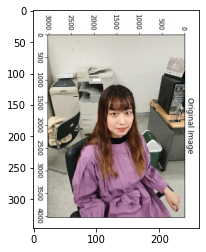

In [ ]:
import matplotlib.pyplot as plt
# load image from file
filename = "/content/Figure_1.jpg"
pixels = plt.imread(filename)
print("Shape of image/array:",pixels.shape)
#pixels=cv2.imdecode(pixels,1)
imgplot = plt.imshow(pixels)
plt.show()

In [ ]:
detector = mtcnn.MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
for face in faces:
    print(face)

{'box': [116, 142, 43, 58], 'confidence': 0.9973791837692261, 'keypoints': {'left_eye': (129, 165), 'right_eye': (150, 163), 'nose': (142, 179), 'mouth_left': (131, 187), 'mouth_right': (148, 186)}}


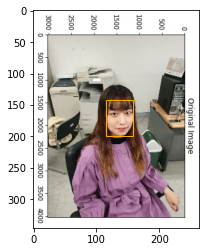

In [ ]:
# draw an image with detected objects
def draw_facebox(filename, result_list):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = plt.Rectangle((x, y), width, height, fill=False, color='orange')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()
 
# filename = 'test1.jpg' # filename is defined above, otherwise uncomment
# load image from file
# pixels = plt.imread(filename) # defined above, otherwise uncomment
# detector is defined above, otherwise uncomment
#detector = mtcnn.MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_facebox(filename, faces)

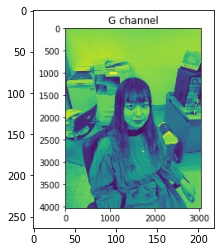

In [ ]:
# draw an image with detected objects
def draw_facebox(filename, result_list):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = plt.Rectangle((x, y), width, height,fill=False, color='orange')
        # draw the box
        ax.add_patch(rect)
        # draw the dots
        for key, value in result['keypoints'].items():
            # create and draw dot
            dot = plt.Circle(value, radius=20, color='red')
            ax.add_patch(dot)
            # show the plot
        plt.show()
 
# filename = 'test1.jpg' # filename is defined above, otherwise uncomment
# load image from file
# pixels = plt.imread(filename) # defined above, otherwise uncomment
# detector is defined above, otherwise uncomment
#detector = mtcnn.MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_facebox(filename, faces)

# Advanced MTCNN 

Speeding up MTCNN with a GPU and faster model
(as in https://www.kaggle.com/timesler/fast-mtcnn-detector-55-fps-at-full-resolution)

for this we will need to install facenet-pytorch

as well as pytorch. Now you will need cuda and everything in the background, so please check out: 

But to set up the right tensorflow, keras, ... version I found it easy to use the following command:
conda install -c anaconda keras-gpu

In [ ]:
!pip install facenet-pytorch 
!conda install -c anaconda keras-gpu

     |████████████████████████████████| 1.9MB 4.3MB/s 
/bin/bash: conda: command not found


In [ ]:
from facenet_pytorch import MTCNN
from PIL import Image
import torch
from imutils.video import FileVideoStream
import cv2
import time
import glob
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

filenames = ["glediston-bastos-ZtmmR9D_2tA-unsplash.jpg","glediston-bastos-ZtmmR9D_2tA-unsplash.jpg"]

In [ ]:
# define our extractor
fast_mtcnn = FastMTCNN(
    stride=4,
    resize=0.5,
    margin=14,
    factor=0.6,
    keep_all=True,
    device=device
)


In [ ]:
def run_detection(fast_mtcnn, filenames):
    frames = []
    frames_processed = 0
    faces_detected = 0
    batch_size = 60
    start = time.time()

    for filename in tqdm(filenames):

        v_cap = FileVideoStream(filename).start()
        v_len = int(v_cap.stream.get(cv2.CAP_PROP_FRAME_COUNT))

        for j in range(v_len):

            frame = v_cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

            if len(frames) >= batch_size or j == v_len - 1:

                faces = fast_mtcnn(frames)

                frames_processed += len(frames)
                faces_detected += len(faces)
                frames = []

                print(
                    f'Frames per second: {frames_processed / (time.time() - start):.3f},',
                    f'faces detected: {faces_detected}\r',
                    end=''
                )

        v_cap.stop()

run_detection(fast_mtcnn, filenames)

#Background removal 

https://www.programmersought.com/article/52544509772/


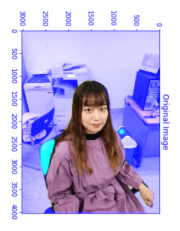

In [ ]:

from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

 
# Apply the transformations needed
import torchvision.transforms as T
 
# Define the helper function
def decode_segmap(image, source, nc=21):
    label_colors = np.array([(192, 128, 0),  # 0=background
                             # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                             (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
                             # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                             (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
                             # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
                             (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
                             # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
                             (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    # Load the foreground input image
    foreground = cv2.imread(source)
    #print('foreground1')
    #print(foreground)
    # Change the color of foreground image to RGB
    # and resize image to match shape of R-band in RGB output map
    foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
    foreground = cv2.resize(foreground, (r.shape[1], r.shape[0]))
    #rint('foreground2')
    # Create a background array to hold white pixels
    # with the same size as RGB output map
    background = 255 * np.ones_like(rgb).astype(np.uint8)
    # Convert uint8 to float
    foreground = foreground.astype(float)
    background = background.astype(float)
    # Create a binary mask of the RGB output map using the threshold value 0
    th, alpha = cv2.threshold(np.array(rgb), 0, 255, cv2.THRESH_BINARY)
    # Apply a slight blur to the mask to soften edges
    #print('alpha1')
    #print(alpha)
    alpha = cv2.GaussianBlur(alpha, (7, 7), 0)
    #print('alpha2')
    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha.astype(float) / 255
    #print('alpha3')
    #print(alpha)
    # Multiply the foreground with the alpha matte
    foreground = cv2.multiply(alpha, foreground)
    # Multiply the background with ( 1 - alpha )
    background = cv2.multiply(1.0 - alpha, background)
    # Add the masked foreground and background
    outImage = cv2.add(foreground, background)
    # Return a normalized output image for display
    # return outImage.astype(int)
    return outImage / 255
 
 
def segment(net, path, show_orig=True, dev='cuda'):
    img = Image.open(path)
    if show_orig:
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(450),
                     # T.CenterCrop(224),
                     T.ToTensor(),
                     T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om, path)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()
 
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()
segment(dlab, '/content/Figure_1.jpg', show_orig=False)